# Interpretability

- https://shap.readthedocs.io/en/latest/

In [1]:
#!pip install shap

In [296]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.impute import SimpleImputer
from tpot.export_utils import set_param_recursive

import shap
import matplotlib as plt

shap.initjs()
pd.options.display.max_columns = None

In [313]:
X1 = pd.read_csv('X1.csv')
X2 = pd.read_csv('X2.csv')
target = pd.read_csv('target.csv')

df_legend = pd.read_excel('df_project2.xlsx', sheet_name = 'data_dictionary') # load the data dictionary

## Model X1

In [314]:
existing_columns_x1 = X1.columns

numeric_cols_x1 = list(set(df_legend[df_legend['isnumeric']==1]['name_col']).intersection(existing_columns_x1))
yes_no_cols_x1 = list(set(df_legend[df_legend['no_yes_vars']==1]['name_col']).intersection(existing_columns_x1))
other_cols_x1 = list(set(df_legend[(df_legend['no_yes_vars']==0) & (df_legend['isnumeric']==0)]['name_col']).intersection(existing_columns_x1))

# add dummy columns that are missing from previous lists
missing_cols_x1 = set(existing_columns_x1).difference(numeric_cols).difference(yes_no_cols).difference(other_cols)

In [316]:
# model X1

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data_x1 = pd.read_csv('X1.csv', dtype=np.float64)
target = pd.read_csv('target.csv')

#features = tpot_data.drop('target', axis=1)
training_features_x1, testing_features_x1, training_target_x1, testing_target_x1 = \
            train_test_split(tpot_data_x1, target, random_state=42)

imputer = SimpleImputer(strategy="median")
imputer.fit(training_features_x1)
training_features_x1 = imputer.transform(training_features_x1)
testing_features_x1 = imputer.transform(testing_features_x1)

# Average CV score on the training set was: 0.9144442303468017
exported_pipeline_x1 = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.7000000000000001, 
                                                   min_samples_leaf=8, min_samples_split=4, n_estimators=100)),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.4, 
                                                       min_samples_leaf=6, min_samples_split=14, n_estimators=100, 
                                                       subsample=1.0)),
    RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.8, min_samples_leaf=16, 
                       min_samples_split=16, n_estimators=100)
)

# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline_x1.steps, 'random_state', 42)

exported_pipeline_x1.fit(training_features_x1, training_target_x1)
results_x1 = exported_pipeline_x1.predict(testing_features_x1)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [317]:
exported_pipeline_x1

Pipeline(steps=[('stackingestimator-1',
                 StackingEstimator(estimator=RandomForestClassifier(max_features=0.7000000000000001,
                                                                    min_samples_leaf=8,
                                                                    min_samples_split=4,
                                                                    random_state=42))),
                ('stackingestimator-2',
                 StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                                        max_depth=6,
                                                                        max_features=0.4,
                                                                        min_samples_leaf=6,
                                                                        min_samples_split=14,
                                                                        random_state=42))),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_features=0.8,
                                        min_samples_leaf=16,
                                        min_samples_split=16,
                                        random_state=42))])

In [318]:
exported_pipeline_x1['randomforestclassifier']

RandomForestClassifier(bootstrap=False, max_features=0.8, min_samples_leaf=16,
                       min_samples_split=16, random_state=42)

In [326]:
explainer_x1 = shap.TreeExplainer(exported_pipeline_x1['randomforestclassifier'])
shap_values_x1 = explainer_x1.shap_values(testing_features_x1)

pd.DataFrame(shap_values_x1).head()

ValueError: Must pass 2-d input. shape=(2, 1081, 60)

In [324]:
explainer = shap.TreeExplainer(exported_pipeline_x1.named_steps["randomforestclassifier"])
shap_values = explainer.shap_values(exported_pipeline_x1[:-1].transform(training_features_x1))
shap_values

#https://github.com/slundberg/shap/issues/1373
#https://stackoverflow.com/questions/55867862/how-to-use-shap-with-a-linear-svc-model-from-sklearn-using-pipeline
#https://datascience.stackexchange.com/questions/52476/how-to-use-shap-kernal-explainer-with-pipeline-models
#https://stackoverflow.com/questions/67394585/shap-or-lime-with-tpot-classifier

[array([[ 0.00190652,  0.03919881,  0.03156116, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00190652,  0.03924715,  0.03160218, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00185584,  0.00031874, -0.0052685 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.00190623,  0.03931062,  0.03174413, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00190652,  0.03919881,  0.03156116, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00190652,  0.03919783,  0.03157676, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[-0.00190652, -0.03919881, -0.03156116, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00190652, -0.03924715, -0.03160218, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00185584, -0.00031874,  0.0052685 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.00190623, -0.03931062, -0.03174413, ...,  

In [288]:
# add labels
df_testing_x1 = pd.DataFrame(testing_features_x1, columns = X1.columns)

### Global

#### Feature Importances

In [325]:
shap.summary_plot(shap_values_x1, df_testing_x1, plot_type="bar", max_display = 30)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

#### SHAP Summary Plot

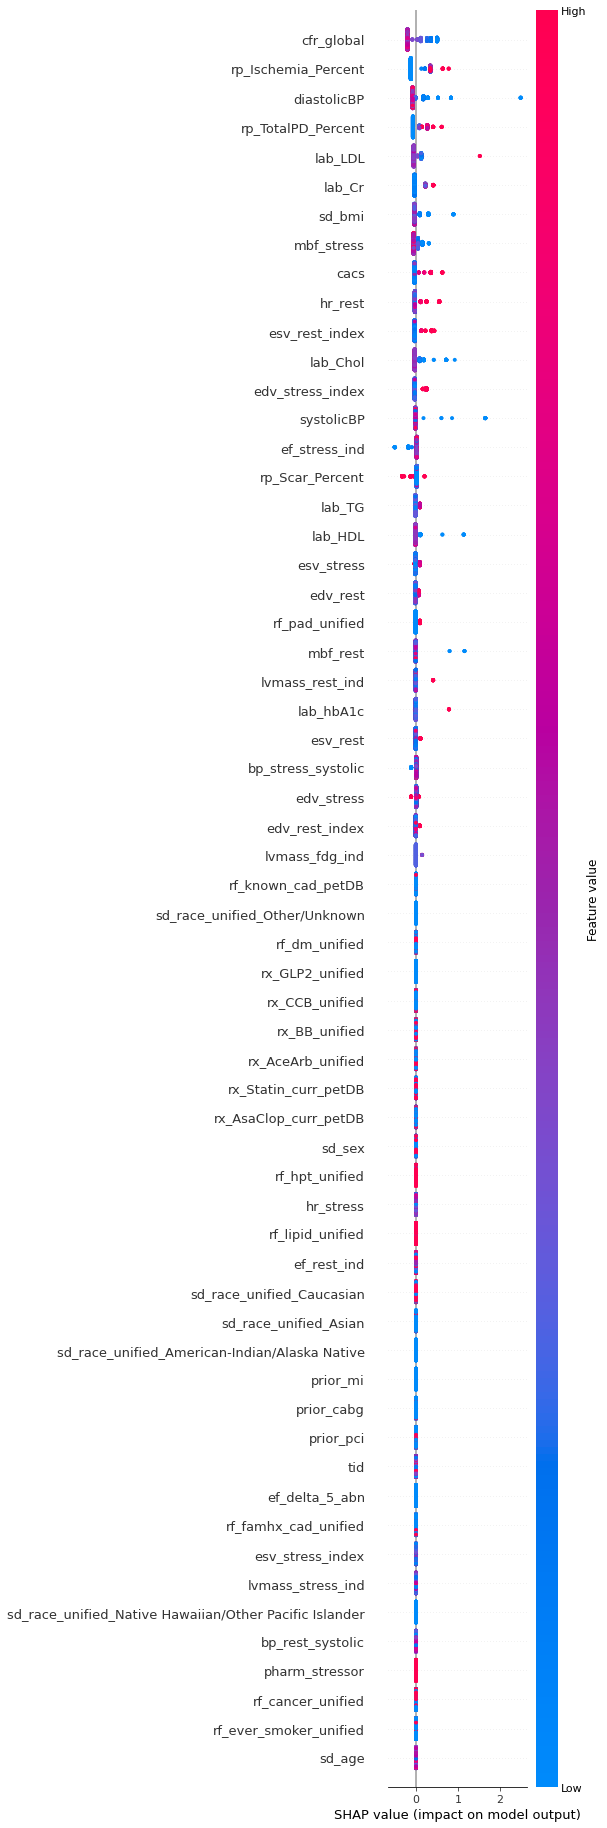

In [254]:
shap.summary_plot(shap_values_x1, df_testing_x1, max_display = 100)

### Local

In [262]:
# mace predicted as 1
np.where(results_x1 == 1)

(array([  23,   99,  242,  371,  568,  572,  609,  661,  817,  819,  828,
         906, 1014, 1068], dtype=int64),)

In [263]:
# actual values as 1
np.where(testing_target_x1 == 1)

(array([   1,   12,   23,   43,   61,   99,  109,  121,  125,  137,  145,
         155,  175,  190,  221,  223,  244,  289,  295,  303,  304,  323,
         364,  366,  454,  508,  534,  551,  568,  571,  572,  583,  588,
         596,  609,  610,  616,  624,  661,  670,  678,  684,  693,  744,
         748,  779,  792,  810,  819,  838,  866,  867,  889,  905,  974,
         978,  980,  996, 1015, 1025, 1036, 1052, 1068, 1075], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int64))

In [264]:
# predicting when mace = 1
shap.initjs()
shap.force_plot(explainer_x1.expected_value, shap_values_x1[23,:], df_testing_x1.iloc[23,:]) # using index x

In [265]:
# predicting when mace=0
shap.initjs()
shap.force_plot(explainer_x1.expected_value, shap_values_x1[390,:], df_testing_x1.iloc[390,:]) # using index x

In [266]:
shap.initjs()
shap.force_plot(explainer_x1.expected_value, shap_values_x1[:1000,:], df_testing_x1.iloc[:1000,:])

### Group

In [267]:
df_results_x1 = pd.DataFrame(results_x1, columns = target.columns)
df_testing_x1 = pd.DataFrame(testing_features_x1, columns = X1.columns)

In [268]:
# combine results with features
combined = pd.concat([df_testing_x1, df_results_x1], axis=1)

In [269]:
# filter data takes in user given filters
# The expected input is a matrix where each array is a key, value pair
# Example of expected input [['sd_sex', 0],['sd_race_unified_Caucasian',1]]

def filterData(data, filters):
    filtered_data = data.copy()
    for filter_pair in filters:
        key, value = filter_pair
        filtered_data = filtered_data.loc[filtered_data[key] == value]
    
    return filtered_data
    
def getMaceArrays(data, filters):
    filtered = filterData(combined, test_filters)

    mace0 = filtered[filtered['o_mace'] == 0]
    mace0 = mace0.drop('o_mace', axis = 1)
    mace1 = filtered[filtered['o_mace'] == 1]
    mace1 = mace1.drop('o_mace', axis = 1)
    return [mace0, mace1]

def getAggregatedData(data, numeric_cols, yes_no_cols, other_cols):
    mace_median = data[numeric_cols].median()
    mace_mode = data[yes_no_cols + other_cols].mode()
    merged = pd.DataFrame(mace_median).T.merge(mace_mode)
    
    return merged

def createForcePlot(pipeline, data, title):
    shap.initjs()
    explainer = shap.TreeExplainer(pipeline)
    shap_values = explainer.shap_values(data)
    print(title)
    return shap.force_plot(explainer.expected_value, shap_values, data)


In [270]:
# select filters
#test_filters = [['sd_sex', 0], ['sd_race_unified_Caucasian',1]]

# 2 datasets: mace=0, mace=1
#mace0, mace1 = getMaceArrays(combined, test_filters)

In [277]:
# select filters
test_filters = [['sd_age', 50]]

# 2 datasets: mace=0, mace=1
mace0, mace1 = getMaceArrays(combined, test_filters)

In [278]:
# aggregate values for group level
mace_0_aggregated_x1 = getAggregatedData(mace0, numeric_cols_x1, yes_no_cols_x1, other_cols_x1)
mace_1_aggregated_x1 = getAggregatedData(mace1, numeric_cols_x1, yes_no_cols_x1, other_cols_x1)

In [279]:
# mace=0
createForcePlot(exported_pipeline_x1, mace_0_aggregated_x1, 'Mace 0')

Mace 0


In [280]:
# mace=1
createForcePlot(exported_pipeline_x1, mace_1_aggregated_x1, 'Mace 1')

Mace 1


In [276]:
from tkinter import *
from IPython.display import clear_output

window=Tk()
window.title('Group Interpretability')
window.geometry("700x300+10+10")
        
# Dropdown menu options
OPTIONS1 = X1.columns
        
columns_copy = list(X1.columns.copy())
columns_copy.insert(0, "none")
        
OPTIONS2 = columns_copy
        
#function to aggregate over the data based on the selections
def oki():
    global test_filters
    global mace0
    global mace1
    global mace_0_aggregated_x1
    global mace_1_aggregated_x1
    if clicked2.get() == "none":
        test_filters = [[clicked1.get(), float(t1.get())]]
    elif clicked3.get() == "none":
        test_filters = [[clicked1.get(), float(t1.get())], [clicked2.get(), float(t2.get())]]
    else:
        test_filters = [[clicked1.get(), float(t1.get())], [clicked2.get(), float(t2.get())], 
                        [clicked3.get(), float(t3.get())]]
                
    mace0, mace1 = getMaceArrays(combined, test_filters)
    mace_0_aggregated_x1 = getAggregatedData(mace0, numeric_cols_x1, yes_no_cols_x1, other_cols_x1)
    mace_1_aggregated_x1 = getAggregatedData(mace1, numeric_cols_x1, yes_no_cols_x1, other_cols_x1)
    label.config( text = test_filters )
    
    #remove this line if you want to keep all the outputs
    clear_output(wait=True)
    
    shap.initjs()
    explainer = shap.TreeExplainer(exported_pipeline_x1)
    shap_values = explainer.shap_values(mace_0_aggregated_x1)
    print(test_filters,"MACE 0")
    display(shap.force_plot(explainer.expected_value, shap_values, mace_0_aggregated_x1))
    
    shap_values = explainer.shap_values(mace_1_aggregated_x1)
    print(test_filters,"MACE 1")
    display(shap.force_plot(explainer.expected_value, shap_values, mace_1_aggregated_x1))
    
# datatype of menu text
clicked1 = StringVar(window)
clicked2 = StringVar(window)
clicked3 = StringVar(window)

# initial menu text
clicked1.set(OPTIONS1[0])
clicked2.set(OPTIONS2[0])
clicked3.set(OPTIONS2[0])

# Create Dropdown menues
drop1 = OptionMenu( window , clicked1 , *OPTIONS1 )
drop1.pack()
drop1.place(x=100, y=50)
drop2 = OptionMenu( window , clicked2 , *OPTIONS2 )
drop2.pack()
drop2.place(x=100, y=100)
drop3 = OptionMenu( window , clicked3 , *OPTIONS2 )
drop3.pack()
drop3.place(x=100, y=150)
        
#Create OK button
button = Button(window, text="OK", command=oki)
button.pack()
button.place(x=150, y=200)
        
#Create exit button
exit_button = Button(window, text="Exit", command=window.destroy)
exit_button.pack(pady=20)
exit_button.place(x=500, y=200)
        
#Create label info window
label = Label( window , text = " " )
label.pack()
        
#Create entry box windows for values
t1=Entry()
t2=Entry()
t3=Entry()
t1.place(x=500, y=50)
t2.place(x=500, y=100)
t3.place(x=500, y=150)

window.mainloop()

[['sd_age', 50.0]] MACE 0


[['sd_age', 50.0]] MACE 1


## Model X2

In [328]:
# model X2

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data_x2 = pd.read_csv('X2.csv', dtype=np.float64)
target = pd.read_csv('target.csv')

training_features_x2, testing_features_x2, training_target_x2, testing_target_x2 = \
            train_test_split(tpot_data_x2, target, random_state=42)

imputer = SimpleImputer(strategy="median")
imputer.fit(training_features_x2)
training_features_x2 = imputer.transform(training_features_x2)
testing_features_x2 = imputer.transform(testing_features_x2)

# Average CV score on the training set was: 0.9126299473614102
exported_pipeline_x2 = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.7000000000000001, 
                                                       min_samples_leaf=8, min_samples_split=4, n_estimators=100)),
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.4, 
                                                           min_samples_leaf=6, min_samples_split=14, n_estimators=100, 
                                                           subsample=1.0)),
    RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.8, min_samples_leaf=16, min_samples_split=16, 
                           n_estimators=100)
)

# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline_x2.steps, 'random_state', 42)

exported_pipeline_x2.fit(training_features_x2, training_target_x2)
results_x2 = exported_pipeline_x2.predict(testing_features_x2)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [292]:
explainer_x2 = shap.TreeExplainer(exported_pipeline_x2['GradientBoostingClassifier'])
shap_values_x2 = explainer_x2.shap_values(testing_features_x2)

pd.DataFrame(shap_values_x2).head()

KeyError: 'classifer'

In [ ]:
# add labels
df_testing_x2 = pd.DataFrame(testing_features_x2, columns = X1.columns)

### Global

#### Feature Importances

#### SHAP Summary Plot

### Local

### Group